In [1]:
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import osmnx as ox
import pandas as pd
ox.config(use_cache=True)

## 1. Load census and boundary data

In [2]:
# 2016 demographic data by postcode
path_demographic_data = '../../ABSData/2016 Census GCP Postal Areas for VIC/2016Census_G01_VIC_POA.csv'
postcode_demographics = pd.read_csv(path_demographic_data)
postcode_demographics.shape

(698, 109)

In [3]:
# postcode boundaries shapefile
path_postcode_boundaries = '../../ABSData/Boundaries/POA_2016_AUST.shp'
postcode_boundaries = gpd.read_file(path_postcode_boundaries)
postcode_boundaries.shape

(2670, 5)

## 2. Geocode hospital location

In [4]:
# geocode MMC to lat-lng
mmc_latlng = ox.geocode('Monash Medical Centre, Clayton, Victoria, Australia')

## 3. Combine demographics and spatial data

In [5]:
gdf = pd.merge(left=postcode_boundaries, right=postcode_demographics,
               how='right', left_on='POA_CODE', right_on='POA_CODE_2016')
gdf.shape

(698, 114)

## 4. Compute per-postcode stroke incidence

Combined male/female incidence per 100,000 persons:

```
Age      Incidence
0-14     0
15-24    5
25-34    30
35-44    44
45-54    111
55-64    299
65-74    747
75-84    1928
85+      3976
```

In [6]:
# count persons between 0 and 24 years of age
cols = ['Age_0_4_yr_P', 'Age_5_14_yr_P', 'Age_15_19_yr_P', 'Age_20_24_yr_P']
gdf['Age_0_24_yr_P'] = gdf[cols].sum(axis=1)

In [7]:
# estimate the stroke count, stratified by age
strokes  = gdf['Age_0_24_yr_P']  * 5    / 100000
strokes += gdf['Age_25_34_yr_P'] * 30   / 100000
strokes += gdf['Age_35_44_yr_P'] * 44   / 100000
strokes += gdf['Age_45_54_yr_P'] * 111  / 100000
strokes += gdf['Age_55_64_yr_P'] * 299  / 100000
strokes += gdf['Age_65_74_yr_P'] * 747  / 100000
strokes += gdf['Age_75_84_yr_P'] * 1928 / 100000
strokes += gdf['Age_85ov_P']     * 3976 / 100000
gdf['strokes'] = strokes.round(2)

In [8]:
# save estimated strokes per postcode to disk as csv
gdf[['POA_CODE', 'strokes']].to_csv('data/postcode_strokes.csv', index=False, encoding='utf-8')

## 5. Compute distance from postcodes to hospital

In [9]:
# re-project gdf to align CRSs then extract lats and lngs
gdf = gdf.to_crs(ox.settings.default_crs)
postcode_lng = gdf['geometry'].centroid.x
postcode_lat = gdf['geometry'].centroid.y
mmc_lng = mmc_latlng[1]
mmc_lat = mmc_latlng[0]

In [10]:
# calculate great-circle distance from each postcode to MMC, in km
gdf['distance_to_mmc'] = ox.great_circle_vec(postcode_lat, postcode_lng, mmc_lat, mmc_lng) / 1000

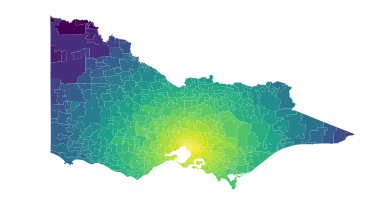

In [11]:
# plot distance as a choropleth
ax = gdf.plot(column='distance_to_mmc', cmap='viridis_r')
ax.axis('off')
plt.show()

## 6. Discard remote postcodes

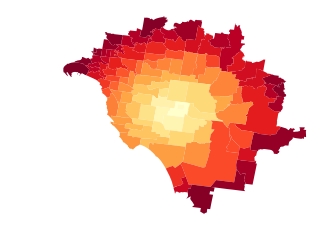

In [12]:
# subset only those postcodes within 20km of MMC
gdf_nearby = gdf[gdf['distance_to_mmc'] < 20]
ax = gdf_nearby.plot(column='distance_to_mmc', cmap='YlOrRd')
ax.axis('off')
plt.show()

## 7. Interactive display of the result

In [13]:
# create leaflet web map
m = folium.Map(location=mmc_latlng, zoom_start=11, tiles='cartodbpositron')

# drop a pin at MMC's location
folium.Marker(mmc_latlng, tooltip='Monash Medical Centre').add_to(m)

# add data as choropleth
bins = list(gdf_nearby['strokes'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1]))
c = folium.Choropleth(gdf_nearby, data=gdf_nearby, bins=bins,
                      columns=['POA_CODE', 'strokes'],
                      key_on='feature.properties.POA_CODE', 
                      highlight=True, fill_color='YlOrRd', 
                      legend_name='Number of strokes').add_to(m)

# add mouseover tooltip to the postcodes
c.geojson.add_child(folium.features.GeoJsonTooltip(['POA_CODE', 'strokes']))

# save web map to disk
m.save('webmap/mmc.html')

In [14]:
# display web map inline
m